In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import *

In [4]:
sample_map = create_sample_map()
obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

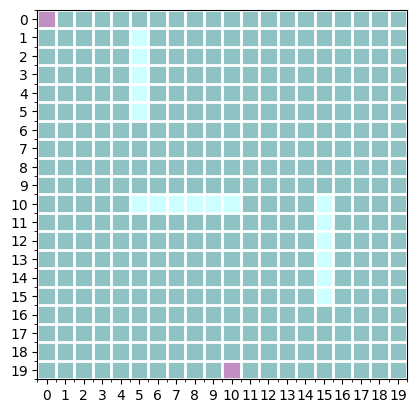

In [5]:
ax = plot_soft_position(obstacle_map, cmap='grey', alpha=0.3)
ax = plot_soft_position(current_pos_map + goal_map, cmap='cool', alpha=0.2, ax=ax)

/Users/kyunghyuncho/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


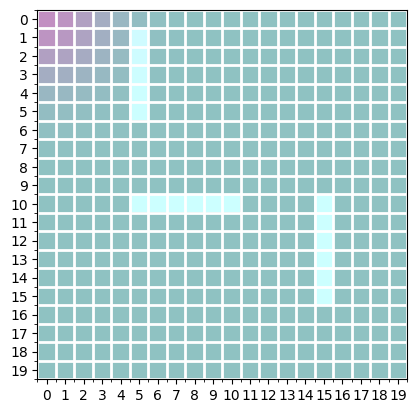

In [6]:
current_coord = get_hard_position(current_pos_map)
current_soft_map = get_soft_position(current_coord[0], current_coord[1], beta=0.1)
current_soft_coord = get_hard_position(current_soft_map)

ax = plot_soft_position(obstacle_map, cmap='grey', alpha=0.3)
ax = plot_soft_position(current_soft_map, cmap='cool', alpha=0.2, ax=ax)

(tensor(8.0000), tensor(8.))


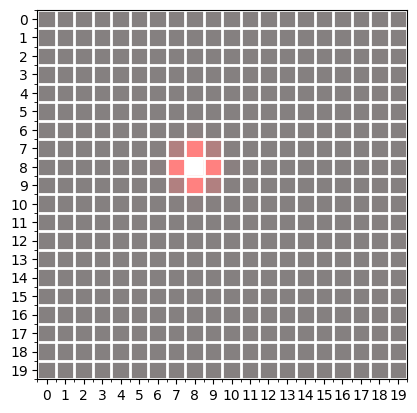

In [7]:
current_soft_map = get_soft_position(8, 8)
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5)

In [16]:
# perform gradient descent on the trajectory
# the beginning is the current position
trajectory = optimize_trajectory(obstacle_map, goal_map, current_pos_map,
                                 trajectory_length=40, 
                                 num_iterations=500, 
                                 learning_rate=1.,
                                 rounding=True)
trajectory = trajectory.detach()

iteration 1/500, score: 1086.2626953125
iteration 2/500, score: 926.0490112304688
iteration 3/500, score: 796.6553955078125
iteration 4/500, score: 686.891357421875
iteration 5/500, score: 625.7266845703125
iteration 6/500, score: 540.72265625
iteration 7/500, score: 488.4346618652344
iteration 8/500, score: 443.51458740234375
iteration 9/500, score: 407.16357421875
iteration 10/500, score: 395.57916259765625
iteration 11/500, score: 374.87652587890625
iteration 12/500, score: 346.1982116699219
iteration 13/500, score: 332.61810302734375
iteration 14/500, score: 320.4657897949219
iteration 15/500, score: 309.81561279296875
iteration 16/500, score: 302.9969482421875
iteration 17/500, score: 296.8494567871094
iteration 18/500, score: 284.2548522949219
iteration 19/500, score: 270.971435546875
iteration 20/500, score: 257.3748779296875
iteration 21/500, score: 243.31903076171875
iteration 22/500, score: 229.2835693359375
iteration 23/500, score: 217.8041534423828
iteration 24/500, score: 

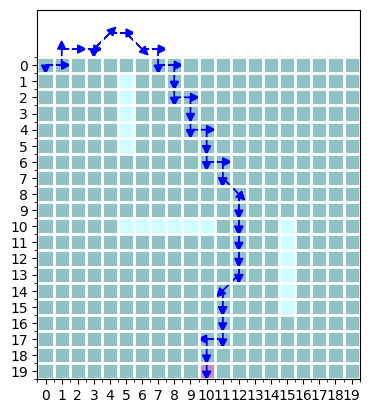

In [17]:
# plot the trajectory
ax = plot_soft_position(obstacle_map, cmap='grey', alpha=0.3)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.2, ax=ax)
for i in range(trajectory.shape[0]):
    if i > 0:
        # draw an arrow from the previous point to the current point in the trajectory.
        ax.arrow(trajectory[i-1, 1], trajectory[i-1, 0], 
                 trajectory[i, 1]-trajectory[i-1, 1], 
                 trajectory[i, 0]-trajectory[i-1, 0], 
                 head_width=0.5, head_length=0.5, fc='b', ec='b')